In [497]:
import pandas as pd
from kmodes.kprototypes import KPrototypes
import ast
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, StandardScaler, RobustScaler
from collections import Counter
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from gower import gower_matrix, gower_dist
from utils import multiple_graphs

In [498]:
%matplotlib inline

## Предварительная обработка датасета

In [499]:
df = pd.read_csv('Result_26_5.csv')

# Делаем преобразования некоторых полей, с помощью библиотеки ast после импорта из csv
for col in df.drop(['profile_id', 'geo'], axis=1).select_dtypes(include='object').columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
df.head()

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,versions
0,6ce3b6b5-280f-4c81-9016-5ec7771202cb,0,RU,"[4f9d83d3-f99e-4f19-80cd-38ff133122ad, f3b446e...","[mobile, mobile, mobile, mobile, mobile]",11963194,0,0,"[drama, youth, thriller, drama, youth, youth, ...","[Молодые и дерзкие, Короткометражное кино, 20 ...","[Movie, Series, Series, Movie, Movie]","[2023-08-27 19:04:12, 2023-08-23 20:40:51, 202...","[2023-08-27 19:25:53, 2023-08-23 21:56:20, 202..."
1,a0d47245-6240-4b04-b189-6226b1569eb2,0,RU,[4f819e7c-6384-433e-9184-e793b8d7d82a],[web],9402,0,0,"[thriller, drama]","[Москва крупным планом, Интриги, Манипуляторы,...",[Series],[2024-05-31 17:22:26],[2024-05-31 17:27:53]
2,18cde70f-00e0-422d-b1ea-57a639615255,0,RU,"[94f12d99-78bf-4785-9b8f-e6eb338abfe9, c0c4fa9...","[tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, t...",503510604,0,0,"[melodrama, drama, comedy, family, melodrama, ...","[Нездоровые отношения, Звездный актерский сост...","[Movie, Series, Series, Series, Movie, Series,...","[2025-04-27 13:29:52, 2025-04-07 10:16:27, 202...","[2025-04-27 13:29:52, 2025-04-07 10:16:27, 202..."
3,476fb1b6-8814-4c33-b154-bce5b7352bd6,1,RU,[1564d800-1fb2-452b-82ee-6b4c88672b9e],[tv],5948100,0,0,"[entertainment, education, talkshow]","[Суперхиты, Дружная семья, Про дружбу, Интерес...",[Series],[2023-08-20 11:27:41],[2023-08-20 13:06:20]
4,70e5db19-435a-4125-b820-7181b4462548,0,DE,"[608da742-46c3-4a5d-8134-532fd391a456, 9eb1e01...","[mobile, mobile, tv, mobile, mobile, mobile, m...",169830607,0,0,"[detective, drama, drama, comedy, drama, drama...","[Ведется расследование, Мрачная атмосфера, Тай...","[Series, Series, Series, Series, Movie, Series...","[2024-01-20 17:55:21, 2024-01-07 09:58:57, 202...","[2024-01-20 19:42:06, 2024-01-07 10:34:05, 202..."


In [500]:
# Определяем самые часто встречающиеся значения в колонках device, genres, hashtags, cls, если таких значений больше одного
# то заменяем их значением "various". Это позволит избежать большого разброса данных.
def most_frequent(row):        
    counts = Counter(row)
    data = [i for i, v in zip(counts.keys(), counts.values()) if v == max(counts.values())]
    if len(data) > 1:
        return 'various'
    return ''.join(data)
for col in ['device', 'genres', 'hashtags', 'cls']:
    df[col] = df[col].apply(most_frequent)
    
# Обрабатываем временные данные. Преобразуем время начала просмотра в колонке "starts" в категории утро, день, вечер, ночь
# И определим самые часто встречающиеся значения. Это также позволит избежать большого разброса данных.

def time_of_day(h):
    if 5 <= h < 11: return 'Morning'
    elif 11 <= h < 17: return 'Day'
    elif 17 <= h < 23: return 'Evening'
    else: return 'Night'


df['period'] =  df['starts'].apply(
    lambda times: [time_of_day(pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').hour) for t in times if t]
).apply(most_frequent)

# Сделаем еще один бинарный признак наиболее часто встречающиеся просмотры по дням недели (будни / выходные)
df['weekdays'] = df['starts'].apply(
    lambda times: [
        'weekend' if pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').weekday() in [5, 6] else 'weekdays'
        for t in times if t
    ]
).apply(most_frequent)

# Сделаем числовой признак - количество просмотров
df['views_count'] = df['product_ids'].map(lambda x: len(x))

# Разделение признаков
num_cols = df.drop('profile_is_child', axis=1).select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.drop(list(num_cols)+['profile_id', 'product_ids', 'starts', 'versions'], axis=1).columns
print(df[cat_cols].head())
df[cat_cols].head()

   profile_is_child geo  device   genres                        hashtags  \
0                 0  RU  mobile    youth               Молодые и дерзкие   
1                 0  RU     web  various                         various   
2                 0  RU      tv    drama  С субтитрами для слабослышащих   
3                 1  RU      tv  various                         various   
4                 0  DE  mobile    drama  С субтитрами для слабослышащих   

      cls   period  weekdays  
0   Movie  Evening   weekend  
1  Series  Evening  weekdays  
2  Series      Day  weekdays  
3  Series      Day   weekend  
4  Series  Evening   weekend  


,profile_is_child,geo,device,genres,hashtags,cls,period,weekdays
0,0,RU,mobile,youth,Молодые и дерзкие,Movie,Evening,weekend
1,0,RU,web,various,various,Series,Evening,weekdays
2,0,RU,tv,drama,С субтитрами для слабослышащих,Series,Day,weekdays
3,1,RU,tv,various,various,Series,Day,weekend
4,0,DE,mobile,drama,С субтитрами для слабослышащих,Series,Evening,weekend


## Анализ датасета
### Сначала числовые признаки

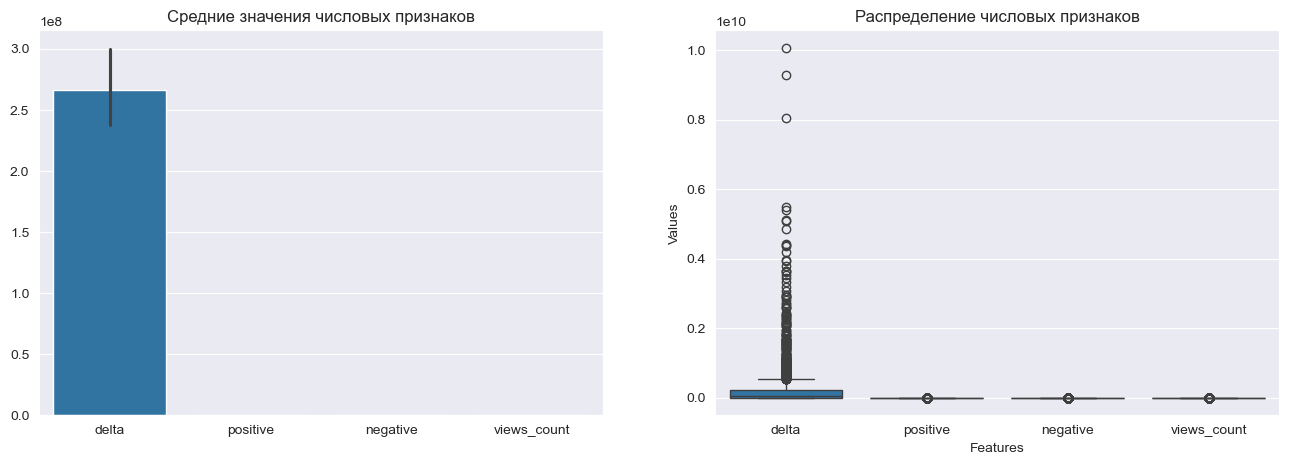

In [501]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(data=df[num_cols], ax=ax1)
ax1.set_title('Средние значения числовых признаков')
sns.boxplot(x='Features', y='Values', data=df[num_cols].melt(var_name='Features', value_name='Values'), ax=ax2)
ax2.set_title('Распределение числовых признаков')
plt.show()

Наблюдаем очень большой разброс и большое количество выбросов в числовых признаках. Необходимо сделать стандартизацию числовых данных

In [502]:
# from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler

# df[num_cols] = df[num_cols].apply(lambda x: winsorize(x, limits=[0.01, 0.01]))
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

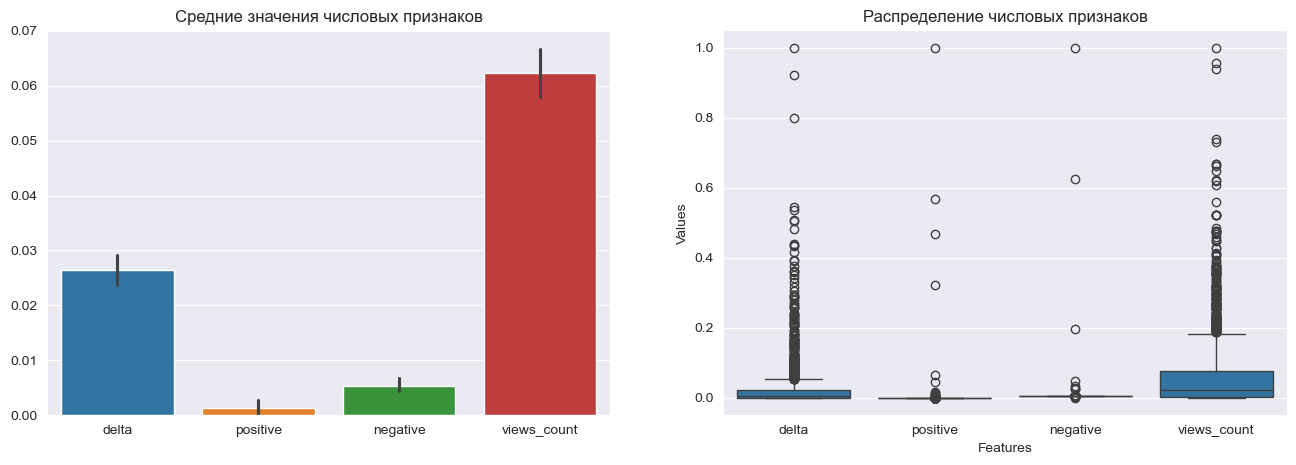

In [503]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(data=df[num_cols], ax=ax1)
ax1.set_title('Средние значения числовых признаков')
sns.boxplot(x='Features', y='Values', data=df[num_cols].melt(var_name='Features', value_name='Values'), ax=ax2)
ax2.set_title('Распределение числовых признаков')
plt.show()

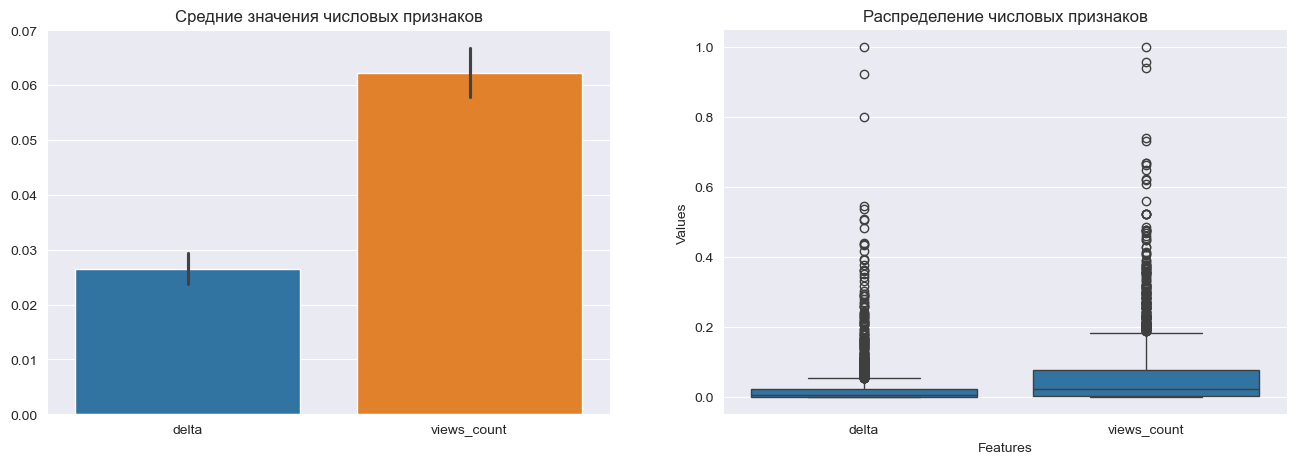

In [504]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(data=df[num_cols].drop(['positive', 'negative'], axis=1), ax=ax1)
ax1.set_title('Средние значения числовых признаков')
sns.boxplot(x='Features', y='Values', data=df[num_cols].drop(['positive', 'negative'], axis=1).melt(var_name='Features', value_name='Values'), ax=ax2)
ax2.set_title('Распределение числовых признаков')
plt.show()

In [505]:
X = pd.concat([df[num_cols].drop(['positive', 'negative', ], axis=1), df[['cls', 'period', 'genres']]], axis=1)
# X = pd.concat([df[num_cols], df[['cls', 'period', 'genres']]], axis=1)
X_train = X.head(200)
n_clusters = []
s_scores =  []
ch_scores = []
costs = []

for k in range(5, 70):
    try:
        k_proto = KPrototypes(n_clusters=k, init='Cao', random_state=42, n_init=3, n_jobs=-1)
        clusters = k_proto.fit_predict(X_train, categorical=[2,3,4])
        Xg = gower_matrix(X_train)
        s_scores.append(silhouette_score(Xg, clusters, metric="precomputed"))
        ch_scores.append(calinski_harabasz_score(Xg, clusters))

        costs.append(k_proto.cost_)
        n_clusters.append(k)
    except Exception as e:
        print(f'{e} Number of clusters {k}')
        break

Clustering algorithm could not initialize. Consider assigning the initial clusters manually. Number of clusters 37


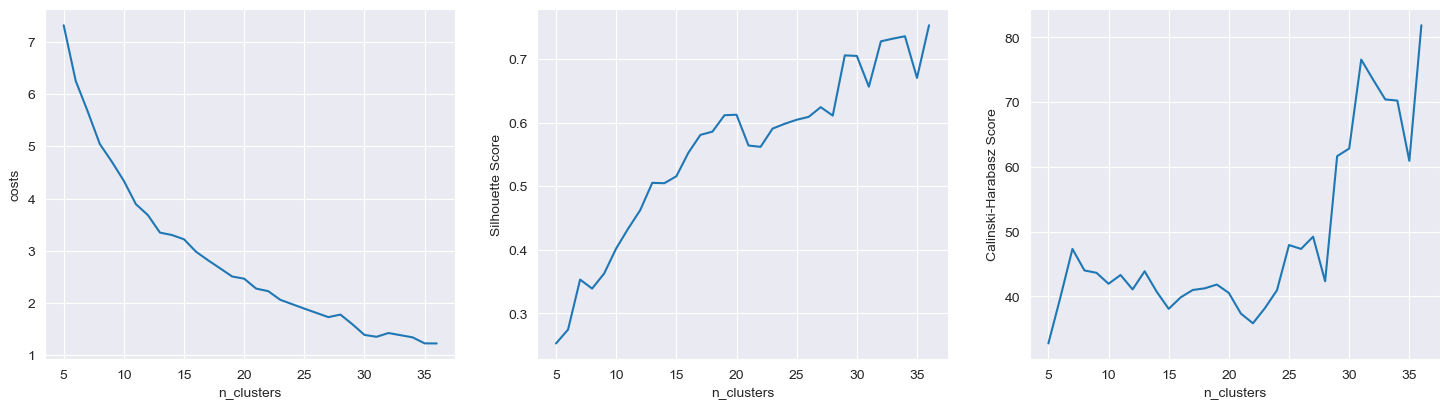

In [506]:
train_results = pd.DataFrame({'n_clusters':n_clusters, 'costs': costs, 'Silhouette Score': s_scores, 'Calinski-Harabasz Score': ch_scores})
multiple_graphs(3, 'n_clusters', train_results)


In [507]:
k_proto = KPrototypes(n_clusters=22, init='Cao', random_state=42, n_jobs=-1)
clusters = k_proto.fit_predict(X, categorical=[2,3,4])
s_score = silhouette_score(gower_matrix(X), clusters, metric="precomputed")
ch_score = calinski_harabasz_score(gower_matrix(X), clusters)
print(f"Silhouette Score: {s_score}")
print(f"Calinski-Harabasz Score: {ch_score}")

Silhouette Score: 0.5415374040603638
Calinski-Harabasz Score: 347.7442738225388
